# Diffrax Scratch
Scratch code testing ODEs using diffrax

In [1]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
# %% Import other libraries
import equinox as eqx
import interpax
import diffrax

import jax.numpy as jnp
import jax.tree_util as jtu
from dataclasses import dataclass
from functools import partial
import numpy as np
from collections import namedtuple
from typing import NamedTuple
import matplotlib.pyplot as plt

In [12]:
# %% Load my own libraries
%load_ext autoreload
%autoreload 2
from c1lgkt.jax.fields.equilibrium import Equilibrium

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


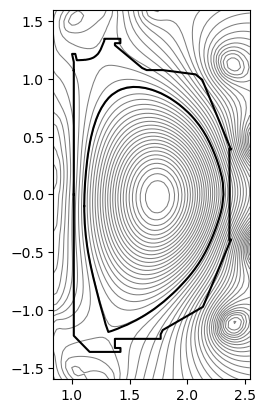

In [13]:
# %% Test loading equilibrium
eq = Equilibrium.from_eqdfile('./tests/D3D141451.eqd')

plt.figure()
ax = plt.subplot(111)
eq.plot_magnetic_geometry(ax)

In [31]:
# %% Pusher along magnetic field lines

class PusherArgs(NamedTuple):
    eq: Equilibrium

def f_fieldline(t, state, args: PusherArgs):
    eq = args.eq

    r, varphi, z = state

    br, bvarphi, bz = eq.compute_bv(r, z)

    drdt = br
    dvarphidt = bvarphi / r  # Convert Bphi to angular velocity
    dzdt = bz

    return (drdt, dvarphidt, dzdt)

term = diffrax.ODETerm(f_fieldline)
solver = diffrax.Dopri5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, 10, 1000))
args = PusherArgs(eq=eq)
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

In [37]:


r0 = jnp.linspace(1.4, 1.6, 50)
z0 = jnp.linspace(-0.1, 0.1, 50)
varphi0 = jnp.zeros_like(r0)

sol = diffrax.diffeqsolve(term, solver, t0=0, t1=10, dt0=1e-3, y0=(r0, varphi0, z0),
                          saveat=saveat, args=args,
                          stepsize_controller=stepsize_controller)

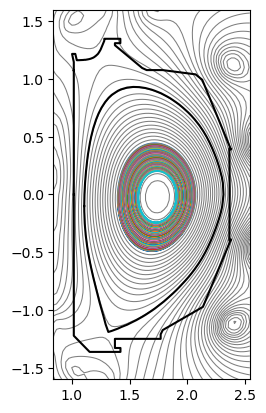

In [38]:
plt.figure()

r, varphi, z = sol.ys
ax = plt.subplot(111)
ax.plot(r, z)
eq.plot_magnetic_geometry(ax)


In [20]:
r.shape

(1000, 10)